# Topics preparation

## 1. Library and data import

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer

In [2]:
df = pd.read_csv("OpenAlex_clean2.csv")

In [3]:
list(df.columns.values)

['Unnamed: 0.1',
 'Unnamed: 0',
 'id',
 'doi',
 'title',
 'publication_year',
 'language',
 'type',
 'countries_distinct_count',
 'institutions_distinct_count',
 'fwci',
 'primary_location.source.display_name',
 'primary_location.source.type',
 'primary_topic.display_name',
 'primary_topic.subfield.display_name',
 'primary_topic.field.display_name',
 'primary_topic.domain.display_name',
 'authorships.author_position',
 'authorships.institutions',
 'authorships.countries',
 'authorships.author.display_name',
 'authorships.raw_affiliation_strings',
 'topics.display_name',
 'topics.subfield.display_name',
 'topics.domain.display_name',
 'keywords.display_name',
 'funders.id',
 'funders.display_name',
 'funders_count',
 'funders_bin']

## 2. Topics column manipulation

### 2.1 Domains one-hot encoding

In [4]:
df['topics.domain.display_name'].unique()

array(['Physical Sciences|Physical Sciences|Physical Sciences',
       'Physical Sciences|Physical Sciences|Life Sciences',
       'Health Sciences|Health Sciences|Health Sciences',
       'Life Sciences|Physical Sciences|Physical Sciences',
       'Health Sciences|Life Sciences|Health Sciences',
       'Social Sciences|Social Sciences|Physical Sciences',
       'Life Sciences|Life Sciences|Life Sciences',
       'Physical Sciences|Physical Sciences|Social Sciences',
       'Health Sciences|Physical Sciences|Physical Sciences',
       'Health Sciences|Life Sciences|Life Sciences',
       'Social Sciences|Social Sciences|Social Sciences',
       'Physical Sciences|Life Sciences|Life Sciences',
       'Social Sciences|Health Sciences|Social Sciences',
       'Physical Sciences', 'Life Sciences|Life Sciences|Health Sciences',
       'Physical Sciences|Life Sciences|Physical Sciences',
       'Life Sciences|Health Sciences|Health Sciences',
       'Life Sciences|Health Sciences',
       'L

In [5]:
# Split the funders and create a new DataFrame with binary columns
split_domains = df['topics.domain.display_name'].str.get_dummies(sep='|')

# Rename the columns to indicate they are domain columns
split_domains = split_domains.rename(
    columns=lambda x: f"domain_{x.lower().replace(' ', '_')}"
)
# Concatenate the new binary columns with the original DataFrame
df = pd.concat([df, split_domains], axis=1)

In [6]:
df.head(3)

,Unnamed: 0.1,Unnamed: 0,id,doi,title,publication_year,language,type,countries_distinct_count,institutions_distinct_count,...,topics.domain.display_name,keywords.display_name,funders.id,funders.display_name,funders_count,funders_bin,domain_health_sciences,domain_life_sciences,domain_physical_sciences,domain_social_sciences
0,0,0,https://openalex.org/W2073832139,https://doi.org/10.1086/300499,Observational Evidence from Supernovae for an ...,1998-01-01,en,article,5.0,20.0,...,Physical Sciences|Physical Sciences|Physical S...,Physics|Astrophysics|Cosmological constant|Sup...,NaN,NaN,0,0,0,0,1,0
1,1,1,https://openalex.org/W1853767801,https://doi.org/10.1086/307221,Measurements of Ω and Λ from 42 High‐Redshift ...,1999-01-01,en,article,6.0,33.0,...,Physical Sciences|Physical Sciences|Physical S...,Supernova|Redshift|Astrophysics|Physics|Astron...,NaN,NaN,0,0,0,0,1,0
2,2,2,https://openalex.org/W1995017064,https://doi.org/10.1107/s0907444998003254,Crystallography &amp; NMR System: A New Softwa...,1998-01-01,en,article,5.0,14.0,...,Physical Sciences|Physical Sciences|Life Sciences,Computer science|Software|Interface (matter)|S...,NaN,NaN,0,0,0,1,1,0


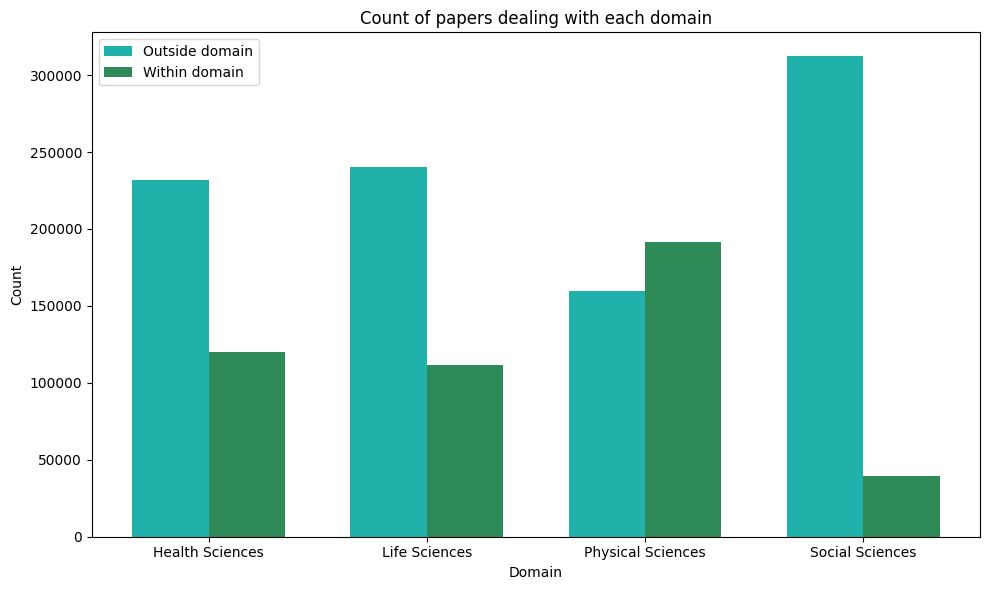

In [7]:
# List of domain columns
domain_columns = [
    'domain_health_sciences',
    'domain_life_sciences',
    'domain_physical_sciences',
    'domain_social_sciences'
]

domain_labels = [
    'Health Sciences',
    'Life Sciences',
    'Physical Sciences',
    'Social Sciences'
]

# Prepare data for plotting
counts_0 = [df[col].value_counts().get(0, 0) for col in domain_columns]
counts_1 = [df[col].value_counts().get(1, 0) for col in domain_columns]

# Set the positions and width for the bars
x = np.arange(len(domain_columns))
width = 0.35

# Create
fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, counts_0, width, label='Outside domain', color='lightseagreen')
rects2 = ax.bar(x + width/2, counts_1, width, label='Within domain', color='seagreen')

# Customize
ax.set_xlabel('Domain')
ax.set_ylabel('Count')
ax.set_title('Count of papers dealing with each domain')
ax.set_xticks(x)
ax.set_xticklabels(domain_labels)
ax.legend()

# Show
plt.tight_layout()
plt.show()


### 2.2 Subfield one-hot-encoding

In [8]:
df['topics.subfield.display_name'].unique()

array(['Astronomy and Astrophysics|Astronomy and Astrophysics|Astronomy and Astrophysics',
       'Spectroscopy|Materials Chemistry|Molecular Biology',
       'Oncology|Otorhinolaryngology|Pulmonary and Respiratory Medicine',
       ...,
       'Occupational Therapy|Oncology|Pulmonary and Respiratory Medicine',
       'Surgery|Otorhinolaryngology|Physiology',
       'Political Science and International Relations|Modeling and Simulation|Political Science and International Relations'],
      shape=(69157,), dtype=object)

In [9]:
# Fill NaN with empty strings, then split
subfields_list = df['topics.subfield.display_name'].fillna("").str.split('|').tolist()

# Use MultiLabelBinarizer to create a sparse matrix
mlb = MultiLabelBinarizer(sparse_output=True)
sparse_matrix = mlb.fit_transform(subfields_list)

# Convert to a DataFrame (sparse)
split_field = pd.DataFrame.sparse.from_spmatrix(
    sparse_matrix,
    index=df.index,
    columns=[f"field_{f.lower().replace(' ', '_')}" for f in mlb.classes_]
)

# Filter for frequent subfields (1% threshold)
field_counts = split_field.astype(bool).sum()
threshold = len(df) * 0.00000001
frequent_field = field_counts[field_counts >= threshold].index

# Keep only frequent subfields
split_field = split_field[frequent_field]
# Remove commas from the field column names
split_field.columns = split_field.columns.str.replace(',', '')

# Concatenate with the original DataFrame
df = pd.concat([df, split_field.fillna(0)], axis=1)

In [11]:
# Print how many columns have been created
num_field_columns = len(split_field.columns)
print(f"Number of field columns created: {num_field_columns}")
# Print column names
list(split_field.columns)

Number of field columns created: 244


['field_',
 'field_accounting',
 'field_acoustics_and_ultrasonics',
 'field_aerospace_engineering',
 'field_aging',
 'field_agronomy_and_crop_science',
 'field_algebra_and_number_theory',
 'field_analytical_chemistry',
 'field_anatomy',
 'field_anesthesiology_and_pain_medicine',
 'field_animal_science_and_zoology',
 'field_anthropology',
 'field_applied_mathematics',
 'field_applied_microbiology_and_biotechnology',
 'field_applied_psychology',
 'field_aquatic_science',
 'field_archeology',
 'field_architecture',
 'field_artificial_intelligence',
 'field_astronomy_and_astrophysics',
 'field_atmospheric_science',
 'field_atomic_and_molecular_physics_and_optics',
 'field_automotive_engineering',
 'field_behavioral_neuroscience',
 'field_biochemistry',
 'field_bioengineering',
 'field_biological_psychiatry',
 'field_biomaterials',
 'field_biomedical_engineering',
 'field_biophysics',
 'field_biotechnology',
 'field_building_and_construction',
 'field_business_and_international_management',

In [12]:
df['field_astronomy_and_astrophysics']

0         1
1         1
2         0
3         0
4         0
         ..
351753    0
351754    0
351755    0
351756    0
351757    0
Name: field_astronomy_and_astrophysics, Length: 351758, dtype: Sparse[int64, 0]

In [13]:
df.head(3)

,Unnamed: 0.1,Unnamed: 0,id,doi,title,publication_year,language,type,countries_distinct_count,institutions_distinct_count,...,field_theoretical_computer_science,field_tourism_leisure_and_hospitality_management,field_toxicology,field_transplantation,field_transportation,field_urban_studies,field_urology,field_virology,field_visual_arts_and_performing_arts,field_water_science_and_technology
0,0,0,https://openalex.org/W2073832139,https://doi.org/10.1086/300499,Observational Evidence from Supernovae for an ...,1998-01-01,en,article,5.0,20.0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,https://openalex.org/W1853767801,https://doi.org/10.1086/307221,Measurements of Ω and Λ from 42 High‐Redshift ...,1999-01-01,en,article,6.0,33.0,...,0,0,0,0,0,0,0,0,0,0
2,2,2,https://openalex.org/W1995017064,https://doi.org/10.1107/s0907444998003254,Crystallography &amp; NMR System: A New Softwa...,1998-01-01,en,article,5.0,14.0,...,0,0,0,0,0,0,0,0,0,0


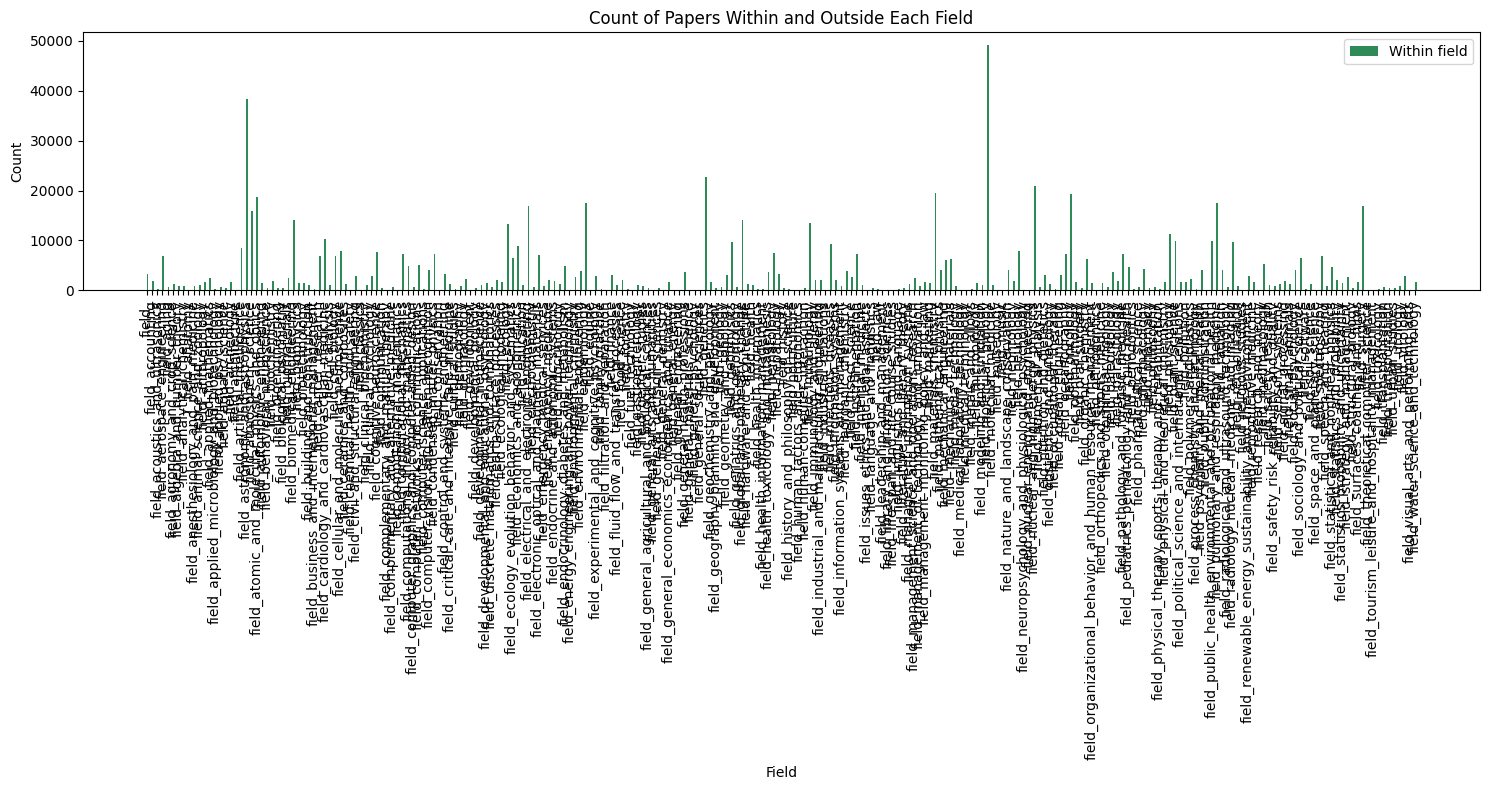

In [14]:
# Update the list of fields
fields = list(split_field.columns)

# Prepare data for plotting
counts_1 = [df[col].value_counts().get(1, 0) for col in fields]

# Set the positions and width for the bars
x = np.arange(len(fields))
width = 0.35

# Create the plot
fig, ax = plt.subplots(figsize=(15, 8))
rects2 = ax.bar(x + width/2, counts_1, width, label='Within field', color='seagreen')

# Customize the plot
ax.set_xlabel('Field')
ax.set_ylabel('Count')
ax.set_title('Count of Papers Within and Outside Each Field')
ax.set_xticks(x)
ax.set_xticklabels(fields, rotation=90)
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()


## 3. Save to csv

In [16]:
df.to_csv("OpenAlex_clean4.csv", sep=",")